In [7]:
import csv
import math
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [8]:
class array:
    def __init__(self, values):
        self.values = list(values)

    def __add__(self, other):
        if isinstance(other, (int, float)):
            return array([x + other for x in self.values])
        elif isinstance(other, array):
            if len(other.values) != len(self.values):
                raise ValueError("Las dimensiones no coinciden")
            return array([x + y for x, y in zip(self.values, other.values)])
        else:
            return NotImplemented

    def __radd__(self, other):
        return self.__add__(other)

    def __truediv__(self, other):
        if isinstance(other, (int, float)):
            if other == 0:
                raise ZeroDivisionError("División por cero")
            return array([x / other for x in self.values])
        elif isinstance(other, array):
            if len(other.values) != len(self.values):
                raise ValueError("Las dimensiones no coinciden")
            for val in other.values:
                if val == 0:
                    raise ZeroDivisionError("División por cero")
            return array([x / y for x, y in zip(self.values, other.values)])
        else:
            return NotImplemented

    def __rtruediv__(self, other):
        if isinstance(other, (int, float)):
            for val in self.values:
                if val == 0:
                    raise ZeroDivisionError("División por cero")
            return array([other / x for x in self.values])
        else:
            return NotImplemented

    def __repr__(self):
        return f"array({self.values})"

    def tolist(self):
        return self.values

    def __iter__(self):
        return iter(self.values)

    def __len__(self):
        return len(self.values)

def arange(start, stop=None, step=1):
    if stop is None:
        stop = start
        start = 0
    if step == 0:
        raise ValueError("step must not be zero")
    values = []
    current = start
    if step > 0:
        while current < stop:
            values.append(current)
            current += step
    else:
        while current > stop:
            values.append(current)
            current += step
    return array(values)

In [9]:
class DecisionTreeRegressorNode:
    def __init__(self, depth=0, max_depth=5):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None

    def fit(self, X, y):
        if len(set(y)) == 1 or self.depth >= self.max_depth or len(X) < 2:
            self.value = sum(y) / len(y) if y else 0.0
            return

        best_var = float('inf')
        best_i, best_t = None, None

        for i in range(len(X[0])):
            values = set(row[i] for row in X)
            for t in values:
                y_left = [y[j] for j in range(len(X)) if X[j][i] <= t]
                y_right = [y[j] for j in range(len(X)) if X[j][i] > t]

                if not y_left or not y_right:
                    continue

                var = (len(y_left) * self.variance(y_left) + len(y_right) * self.variance(y_right)) / len(X)

                if var < best_var:
                    best_var, best_i, best_t = var, i, t

        if best_i is None:
            self.value = sum(y) / len(y) if y else 0.0
            return

        self.feature_index = best_i
        self.threshold = best_t

        X_left, y_left, X_right, y_right = [], [], [], []
        for i in range(len(X)):
            if X[i][self.feature_index] <= self.threshold:
                X_left.append(X[i])
                y_left.append(y[i])
            else:
                X_right.append(X[i])
                y_right.append(y[i])

        self.left = DecisionTreeRegressorNode(self.depth+1, self.max_depth)
        self.right = DecisionTreeRegressorNode(self.depth+1, self.max_depth)
        self.left.fit(X_left, y_left)
        self.right.fit(X_right, y_right)

    def predict(self, x):
        if self.value is not None:
            return self.value
        if x[self.feature_index] <= self.threshold:
            return self.left.predict(x)
        else:
            return self.right.predict(x)

    def variance(self, y):
        if not y:
            return 0.0
        mean = sum(y)/len(y)
        return sum((val - mean) ** 2 for val in y) / len(y)

In [10]:
class RandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = len(X)
        for _ in range(self.n_estimators):
            indices = [random.randint(0, n_samples-1) for _ in range(n_samples)]
            X_sample = [X[i] for i in indices]
            y_sample = [y[i] for i in indices]

            tree = DecisionTreeRegressorNode(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        preds = []
        for x in X:
            values = [tree.predict(x) for tree in self.trees]
            preds.append(sum(values) / len(values) if values else 0.0) # Handle case of empty values
        return preds

In [11]:
class NaiveBayesRegressor:
    def __init__(self, bins=10):
        self.bins = bins
        self.x_ranges = []
        self.y_range = (0, 1) # Default range
        self.counts = defaultdict(lambda: defaultdict(int))
        self.y_totals = defaultdict(int)
        self.total = 0

    def digitize(self, value, value_range):
        step = (value_range[1] - value_range[0]) / self.bins
        if step == 0: # Handle case where range is zero (all values are the same)
            return 0
        return min(self.bins - 1, int((value - value_range[0]) / step))

    def fit(self, X, y):
        if not X or not y or len(X) != len(y):
            return # Handle empty input

        x_ranges = [(min(f), max(f)) for f in zip(*X)] if X else []
        y_range = (min(y), max(y)) if y else (0, 1)

        self.x_ranges = x_ranges
        self.y_range = y_range

        self.counts = defaultdict(lambda: defaultdict(int))
        self.y_totals = defaultdict(int)
        self.total = 0

        for xi, yi in zip(X, y):
            xi_d = tuple(self.digitize(val, r) for val, r in zip(xi, x_ranges))
            yi_d = self.digitize(yi, y_range)
            self.counts[xi_d][yi_d] += 1
            self.y_totals[yi_d] += 1
            self.total += 1

    def predict(self, X):
        preds = []
        for xi in X:
            if not self.x_ranges: # Handle case where model was not fitted
                preds.append((self.y_range[0] + self.y_range[1]) / 2.0)
                continue

            xi_d = tuple(self.digitize(val, r) for val, r in zip(xi, self.x_ranges))
            total_count = sum(self.counts[xi_d].values())

            if total_count == 0:
                mean_y_d = sum(yi_d * count for yi_d, count in self.y_totals.items()) / self.total if self.total > 0 else 0
                step = (self.y_range[1] - self.y_range[0]) / self.bins
                pred_value = mean_y_d * step + self.y_range[0]
                preds.append(pred_value)
                continue

            y_est = sum(yi * count for yi, count in self.counts[xi_d].items()) / total_count
            step = (self.y_range[1] - self.y_range[0]) / self.bins
            pred_value = y_est * step + self.y_range[0]
            preds.append(pred_value)
        return preds

In [12]:
class HMMRegressor:
    def __init__(self, n_states=3, n_bins=5, n_iter=10):
        self.n_states = n_states
        self.n_bins = n_bins
        self.n_iter = n_iter
        self.A = None
        self.B = None
        self.pi = None
        self.y_range = (0, 1)

    def digitize(self, Y, y_range):
        bin_step = (y_range[1] - y_range[0]) / self.n_bins
        if bin_step == 0:
            return [0] * len(Y)
        return [min(self.n_bins - 1, int((y - y_range[0]) / bin_step)) for y in Y]

    def forward(self, obs_seq):
        T = len(obs_seq)
        alpha = [[0.0] * self.n_states for _ in range(T)]

        for i in range(self.n_states):
            alpha[0][i] = self.pi[i] * self.B[i][obs_seq[0]]

        for t in range(1, T):
            for j in range(self.n_states):
                alpha[t][j] = sum(alpha[t-1][i] * self.A[i][j] for i in range(self.n_states)) * self.B[j][obs_seq[t]]

        for t in range(T):
            scale = sum(alpha[t])
            if scale > 0:
                for i in range(self.n_states):
                    alpha[t][i] /= scale
            else:
                 alpha[t] = [1.0/self.n_states] * self.n_states

        return alpha

    def backward(self, obs_seq):
        T = len(obs_seq)
        beta = [[0.0] * self.n_states for _ in range(T)]

        for i in range(self.n_states):
            beta[T-1][i] = 1.0

        for t in range(T-2, -1, -1):
            for i in range(self.n_states):
                beta[t][i] = sum(self.A[i][j] * self.B[j][obs_seq[t+1]] * beta[t+1][j] for j in range(self.n_states))

            scale = sum(beta[t])
            if scale > 0:
                for i in range(self.n_states):
                    beta[t][i] /= scale
            else:
                 beta[t] = [1.0/self.n_states] * self.n_states

        return beta

    def viterbi(self, obs_seq):
        T = len(obs_seq)
        delta = [[0.0] * self.n_states for _ in range(T)]
        psi = [[0] * self.n_states for _ in range(T)]

        for i in range(self.n_states):
            delta[0][i] = self.pi[i] * self.B[i][obs_seq[0]]

        for t in range(1, T):
            for j in range(self.n_states):
                max_prob = 0.0
                max_state = 0
                for i in range(self.n_states):
                    prob = delta[t-1][i] * self.A[i][j]
                    if prob > max_prob:
                        max_prob = prob
                        max_state = i
                delta[t][j] = max_prob * self.B[j][obs_seq[t]]
                psi[t][j] = max_state

        q_T = 0
        max_prob_T = 0.0
        for i in range(self.n_states):
            if delta[T-1][i] > max_prob_T:
                max_prob_T = delta[T-1][i]
                q_T = i

        state_sequence = [0] * T
        state_sequence[T-1] = q_T
        for t in range(T-2, -1, -1):
            state_sequence[t] = psi[t+1][state_sequence[t+1]]

        return state_sequence

    def em_step(self, sequences):
        smoothing = 1e-9
        total_pi_counts = [smoothing] * self.n_states
        total_epsilon_sum = [[smoothing] * self.n_states for _ in range(self.n_states)]
        total_emission_counts = [[smoothing] * self.n_bins for _ in range(self.n_states)]
        total_gamma_sum_states = [smoothing] * self.n_states

        for _, y_seq in sequences:
            obs_seq = self.digitize(y_seq, self.y_range)
            T = len(obs_seq)

            if T == 0:
                continue

            alpha = self.forward(obs_seq)
            beta = self.backward(obs_seq)

            gamma = [[0.0] * self.n_states for _ in range(T)]
            epsilon = [[[0.0] * self.n_states for _ in range(self.n_states)] for _ in range(T - 1)]

            for t in range(T):
                denominator = sum(alpha[t][i] * beta[t][i] for i in range(self.n_states))
                if denominator > 0:
                    for i in range(self.n_states):
                        gamma[t][i] = (alpha[t][i] * beta[t][i]) / denominator
                else:
                     gamma[t] = [1.0/self.n_states] * self.n_states


            for t in range(T - 1):
                denominator = sum(alpha[t][i] * self.A[i][j] * self.B[j][obs_seq[t+1]] * beta[t+1][j]
                                  for i in range(self.n_states) for j in range(self.n_states))
                if denominator > 0:
                    for i in range(self.n_states):
                        for j in range(self.n_states):
                            epsilon[t][i][j] = (alpha[t][i] * self.A[i][j] * self.B[j][obs_seq[t+1]] * beta[t+1][j]) / denominator
                else:
                     for i in range(self.n_states):
                        for j in range(self.n_states):
                            epsilon[t][i][j] = 1.0 / (self.n_states * self.n_states)


            total_pi_counts = [total_pi_counts[i] + gamma[0][i] for i in range(self.n_states)]

            for i in range(self.n_states):
                for j in range(self.n_states):
                    total_epsilon_sum[i][j] += sum(epsilon[t][i][j] for t in range(T - 1))

            for t in range(T):
                for i in range(self.n_states):
                    total_emission_counts[i][obs_seq[t]] += gamma[t][i]
                    total_gamma_sum_states[i] += gamma[t][i]


        sum_total_pi_counts = sum(total_pi_counts)
        if sum_total_pi_counts > 0:
            self.pi = [count / sum_total_pi_counts for count in total_pi_counts]
        else:
             self.pi = [1.0 / self.n_states] * self.n_states

        for i in range(self.n_states):
            sum_total_transitions_from_i = sum(total_epsilon_sum[i])
            if sum_total_transitions_from_i > 0:
                for j in range(self.n_states):
                    self.A[i][j] = total_epsilon_sum[i][j] / sum_total_transitions_from_i
            else:
                 self.A[i] = [1.0 / self.n_states] * self.n_states

        for i in range(self.n_states):
             if total_gamma_sum_states[i] > 0:
                  for k in range(self.n_bins):
                       self.B[i][k] = total_emission_counts[i][k] / total_gamma_sum_states[i]
             else:
                  self.B[i] = [1.0 / self.n_bins] * self.n_bins


    def fit(self, sequences):
        all_y = [y for _, seq_y in sequences for y in seq_y]
        if not all_y:
             self.y_range = (0, 1)
        else:
            self.y_range = (min(all_y), max(all_y))

        self.A = [[1.0/self.n_states]*self.n_states for _ in range(self.n_states)]
        self.B = [[1.0/self.n_bins]*self.n_bins for _ in range(self.n_states)]
        self.pi = [1.0/self.n_states] * self.n_states

        for i in range(self.n_iter):
            self.em_step(sequences)

    def predict_next(self, y_seq_known):
        obs_seq = self.digitize(y_seq_known, self.y_range)
        T = len(obs_seq)

        if T == 0:
            return (self.y_range[0] + self.y_range[1]) / 2.0

        alpha = self.forward(obs_seq)
        last_state_probs = [alpha[T-1][i] for i in range(self.n_states)]

        estimated_next_obs_bin = 0
        for j in range(self.n_states):
             expected_bin_value = sum(k * self.B[j][k] for k in range(self.n_bins))
             estimated_next_obs_bin += last_state_probs[j] * expected_bin_value

        step = (self.y_range[1] - self.y_range[0]) / self.n_bins
        return estimated_next_obs_bin * step + self.y_range[0]

    def predict(self, X):
        predictions = []
        for y_seq_known in X:
            if not y_seq_known:
                predictions.append((self.y_range[0] + self.y_range[1]) / 2.0)
            else:
                 predictions.append(self.predict_next(y_seq_known))
        return predictions

## Carga y división de datos

In [13]:
# Function to load data from a CSV file

def cargar_datos_csv(ruta):
    X, y = [], []  # Initialize lists for features (X) and target (y)
    # Open the CSV file
    with open(ruta, newline='', encoding='utf-8') as f:
        # Create a dictionary reader
        lector = csv.DictReader(f)
        # Iterate over each row in the CSV
        for fila in lector:
            # Extract relevant columns and convert them to float
            X.append([
                float(fila['Open']),
                float(fila['High']),
                float(fila['Low']),
                float(fila['Volume']),
                float(fila['Marketcap']),
            ])
            # Extract the target variable (Close price) and convert to float
            y.append(float(fila['Close']))
    # Return the features and target lists
    return X, y

# Custom implementation of a train-test split function

def train_test_split(X, y, test_size=0.2, shuffle=True, random_state=None):
    # Set random seed if provided for reproducibility
    if random_state is not None:
        random.seed(random_state)
    idxs = list(range(len(X)))  # Get indices of the data
    # Shuffle indices if shuffle is True
    if shuffle:
        random.shuffle(idxs)
    # Calculate the split point
    split = int(len(X) * (1 - test_size))
    # Split indices into training and testing sets
    train_idx, test_idx = idxs[:split], idxs[split:]
    # Create training and testing sets for features and target
    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]
    X_test = [X[i] for i in test_idx]
    y_test = [y[i] for i in test_idx]
    # Return the split datasets
    return X_train, X_test, y_train, y_test

# Load data from the CSV file
X, y = cargar_datos_csv('coin_Bitcoin.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Entrenamiento y evaluación de cada modelo


### RandomForest Regressor: Entrenamiento y Evaluación



In [ ]:
# Initialize and train the RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=10, max_depth=5)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse_rf = sum((yt - yp) ** 2 for yt, yp in zip(y_test, y_pred)) / len(y_test)
print(f"Error cuadrático medio en test (RandomForest): {mse_rf:.2f}")

# Calculate the R^2 score (Coefficient of Determination) manually
media_rf = sum(y_test) / len(y_test)
ss_tot_rf = sum((yt - media_rf) ** 2 for yt in y_test)
ss_res_rf = sum((yt - yp) ** 2 for yt, yp in zip(y_test, y_pred))
r2_rf = 1 - (ss_res_rf / ss_tot_rf)
print(f"Coef. de determinación R^2 (RandomForest): {r2_rf:.4f}")

### Naive Bayes Regressor: Entrenamiento y Evaluación



In [ ]:
# Initialize and train the NaiveBayesRegressor model
nb = NaiveBayesRegressor()
nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = nb.predict(X_test) # Use a different variable name for Naive Bayes predictions

# Calculate the Mean Squared Error (MSE) for Naive Bayes
mse_nb = sum((yt - yp) ** 2 for yt, yp in zip(y_test, y_pred_nb)) / len(y_test)
print(f"Error cuadrático medio en test (Naive Bayes): {mse_nb:.2f}")

# Calculate the R^2 score for Naive Bayes manually
media_nb = sum(y_test) / len(y_test)
ss_tot_nb = sum((yt - media_nb) ** 2 for yt in y_test)
ss_res_nb = sum((yt - yp) ** 2 for yt, yp in zip(y_test, y_pred_nb))
r2_nb = 1 - (ss_res_nb / ss_tot_nb)
print(f"Coef. de determinación R^2 (Naive Bayes): {r2_nb:.4f}")

Error cuadrático medio en test (Naive Bayes): 14906494.73
Coef. de determinación R^2 (Naive Bayes): 0.8524


### HMM Regressor: Entrenamiento y Evaluación



In [ ]:
# Create sequences of the target variable (y_train) with a window size of 10
window_size = 10
sequences = [([0]*len(y_seq), y_seq) for y_seq in [y_train[i:i+window_size] for i in range(0, len(y_train)-window_size)]]

# Initialize the HMMRegressor model with EM (using the corrected class)
hmm = HMMRegressor(n_states=3, n_bins=5, n_iter=10)

# Train the HMM model on the sequences
hmm.fit(sequences)

# Prepare test sequences for batch prediction
X_test_sequences = [y_test[i:i+window_size] for i in range(len(y_test) - window_size)]
y_test_actual = y_test[window_size:] # The actual values corresponding to the predictions

# Make predictions on the test sequences
y_pred_hmm = hmm.predict(X_test_sequences)

# Calculate the Mean Squared Error (MSE) for HMM
mse_hmm = sum((yt - yp) ** 2 for yt, yp in zip(y_test_actual, y_pred_hmm)) / len(y_pred_hmm)
print(f"Error cuadrático medio en test (HMM): {mse_hmm:.2f}")

# Calculate the R^2 score for HMM manually
media_hmm = sum(y_test_actual) / len(y_test_actual)
ss_tot_hmm = sum((yt - media_hmm) ** 2 for yt in y_test_actual)
ss_res_hmm = sum((yt - yp) ** 2 for yt, yp in zip(y_test_actual, y_pred_hmm))
r2_hmm = 1 - (ss_res_hmm / ss_tot_hmm)
print(f"Coef. de determinación R^2 (HMM): {r2_hmm:.4f}")

Error cuadrático medio en test (HMM): 112625004.89
Coef. de determinación R^2 (HMM): -0.1009


## Visualizaciones de Resultados


#### RandomForest Regressor



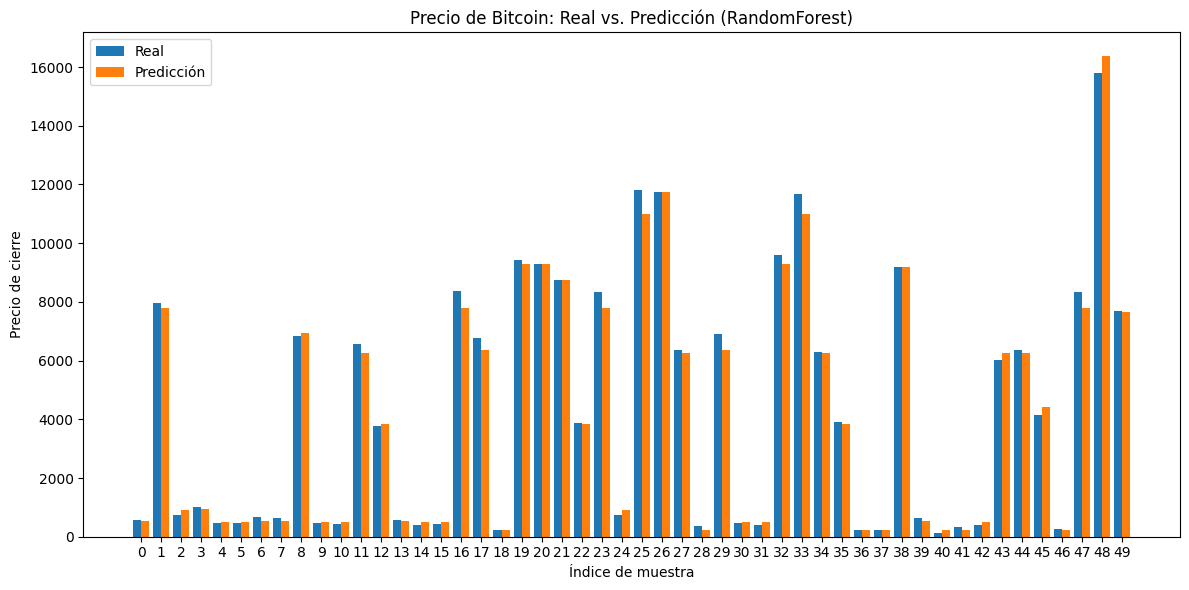

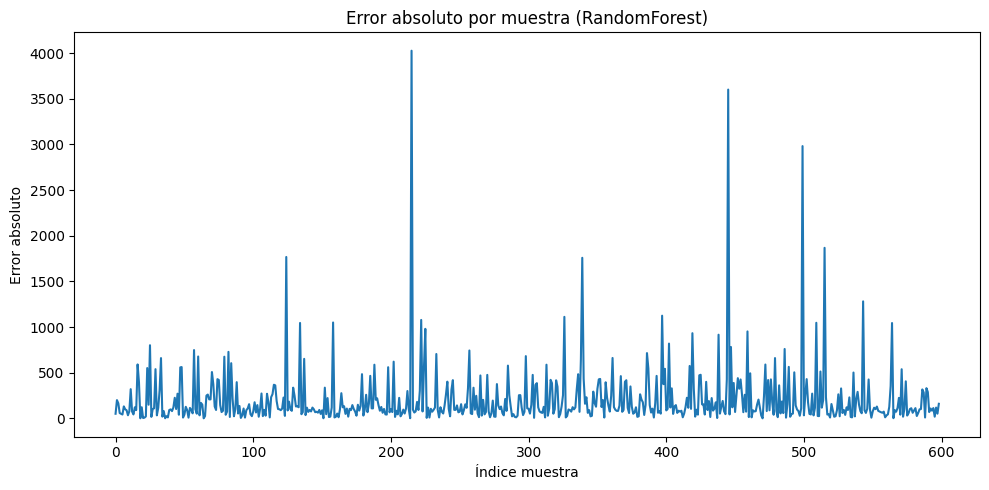

In [ ]:
# Visualize actual vs. predicted prices for a subset of the test data
num_samples = 50  # Number of samples to display
indices = arange(num_samples)  # Generate indices using the custom arange function
bar_width = 0.40  # Width of the bars in the bar plot

# Take a slice of the actual and predicted values
y_test_slice = y_test[:num_samples]
y_pred_slice = y_pred[:num_samples]

# Create a figure and an axes for the bar plot
fig, ax = plt.subplots(figsize=(12,6))

# Create bar plots for actual and predicted values
rects1 = ax.bar(indices.values, y_test_slice, bar_width, label='Real', color='tab:blue')
rects2 = ax.bar((indices+bar_width).values, y_pred_slice, bar_width, label='Predicción', color='tab:orange')

# Calculate positions for the x-axis ticks
center_positions = (indices + (indices + bar_width)) / 2

# Set labels and title for the bar plot
plt.xlabel('Índice de muestra')
plt.ylabel('Precio de cierre')
plt.title('Precio de Bitcoin: Real vs. Predicción (RandomForest)')

# Set x-axis ticks and labels
ax.set_xticks(center_positions.tolist())
ax.set_xticklabels([str(i) for i in indices])

# Add a legend to the bar plot
ax.legend()

# Adjust layout to prevent overlapping elements
plt.tight_layout()
# Display the bar plot
plt.show()

# Visualize the absolute errors of the predictions
# Calculate the absolute difference between actual and predicted values
errores_rf = [abs(yt - yp) for yt, yp in zip(y_test, y_pred)] # Use unique variable name

# Create a figure for the error plot
plt.figure(figsize=(10,5))
# Plot the absolute errors
plt.plot(errores_rf)
# Set title and labels for the error plot
plt.title('Error absoluto por muestra (RandomForest)')
plt.xlabel('Índice muestra')
plt.ylabel('Error absoluto')
# Adjust layout
plt.tight_layout()
# Display the error plot
plt.show()

#### Naive Bayes Regressor



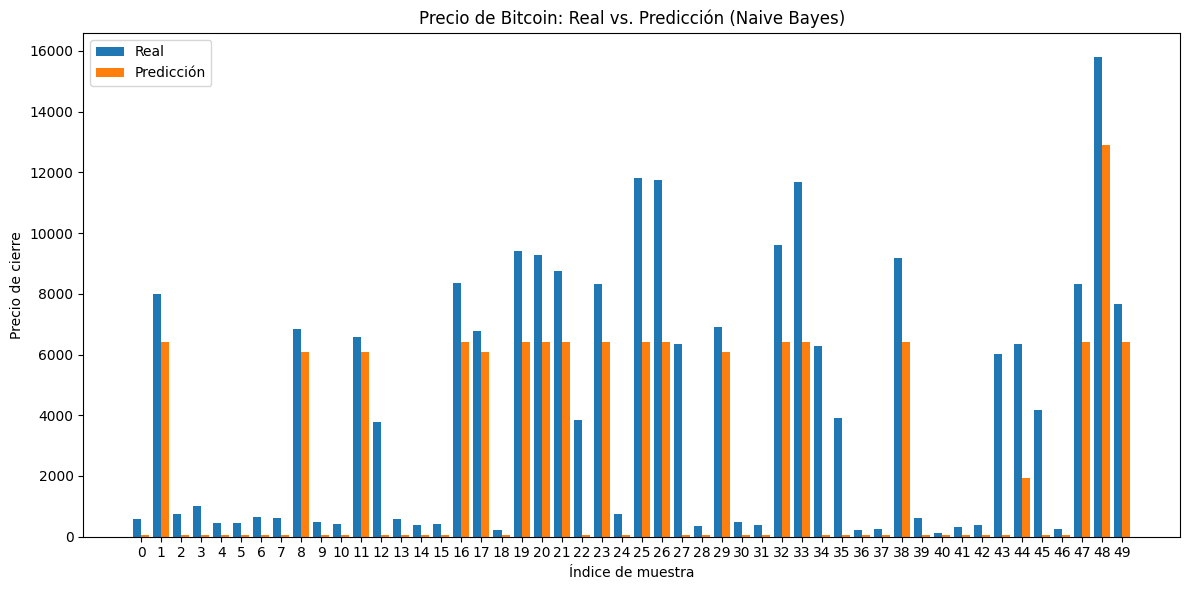

In [ ]:
# Visualize actual vs. predicted prices for a subset of the test data with Naive Bayes predictions

num_samples = 50  # Number of samples to display
indices = arange(num_samples)  # Generate indices using the custom arange function
bar_width = 0.40  # Width of the bars in the bar plot

# Take a slice of the actual and predicted values
y_test_slice_nb = y_test[:num_samples] # Use unique variable names
y_pred_slice_nb = y_pred_nb[:num_samples] # Use unique variable names

# Create a figure and an axes for the plot
fig, ax = plt.subplots(figsize=(12,6))

# Create bar plots for actual and predicted values
rects1 = ax.bar(indices.values, y_test_slice_nb, bar_width, label='Real', color='tab:blue')
rects2 = ax.bar((indices+bar_width).values, y_pred_slice_nb, bar_width, label='Predicción', color='tab:orange')

# Calculate positions for the x-axis ticks
center_positions = (indices + (indices + bar_width)) / 2

# Set labels and title for the plot
plt.xlabel('Índice de muestra')
plt.ylabel('Precio de cierre')
plt.title('Precio de Bitcoin: Real vs. Predicción (Naive Bayes)')

# Set x-axis ticks and labels
ax.set_xticks(center_positions.tolist())
ax.set_xticklabels([str(i) for i in indices])

# Add a legend to the plot
ax.legend()

# Adjust layout to prevent overlapping elements
plt.tight_layout()
# Display the plot
plt.show()

#### HMM Regressor

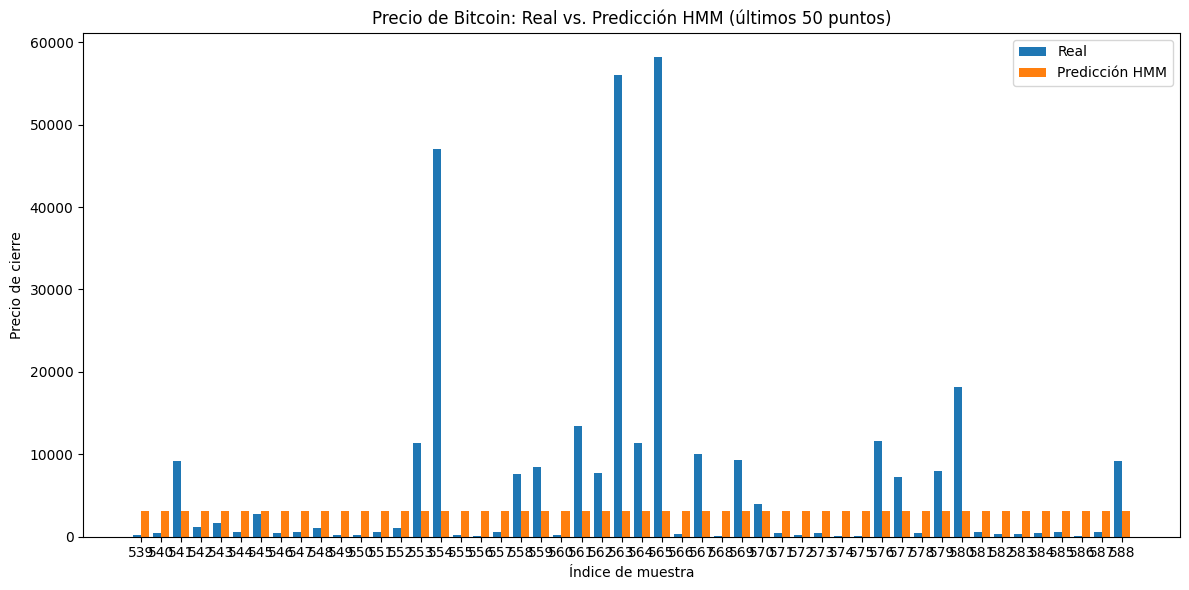

In [ ]:
# Visualize actual vs. predicted values for HMM
num_samples_to_plot = 50 # Number of samples to display
start_index = len(y_test_actual) - num_samples_to_plot

# Ensure start_index is not negative if the test set is smaller than num_samples_to_plot
if start_index < 0:
    start_index = 0
    num_samples_to_plot = len(y_test_actual)

y_test_slice_hmm = y_test_actual[start_index:start_index+num_samples_to_plot] # Use unique variable names
y_pred_slice_hmm = y_pred_hmm[start_index:start_index+num_samples_to_plot] # Use unique variable names

indices = arange(num_samples_to_plot)
bar_width = 0.40

fig, ax = plt.subplots(figsize=(12,6))

rects1 = ax.bar(indices.values, y_test_slice_hmm, bar_width, label='Real', color='tab:blue')
rects2 = ax.bar((indices+bar_width).values, y_pred_slice_hmm, bar_width, label='Predicción HMM', color='tab:orange')

center_positions = (indices + (indices + bar_width)) / 2

plt.xlabel('Índice de muestra')
plt.ylabel('Precio de cierre')
plt.title(f'Precio de Bitcoin: Real vs. Predicción HMM (últimos {num_samples_to_plot} puntos)')

# Adjust x-axis tick labels to reflect the actual index in the test set
ax.set_xticks(center_positions.tolist())
ax.set_xticklabels([str(i) for i in range(start_index, start_index + num_samples_to_plot)])

ax.legend()
plt.tight_layout()
plt.show()

# Análisis y Comparación de Modelos de Regresión para Precios de Bitcoin

Este notebook contiene la implementación y evaluación de tres modelos de regresión personalizados (RandomForest, Naive Bayes y Hidden Markov Model - HMM) aplicados a datos históricos del precio de Bitcoin. El objetivo es comparar su rendimiento en la predicción de precios.

### Implementación de Clases de Modelos de Regresión

Esta sección define las clases personalizadas para los modelos de regresión utilizados en el análisis, incluyendo una clase `array` similar a NumPy y funciones auxiliares.

### Carga y División de Datos

En esta sección, se carga el conjunto de datos históricos del precio de Bitcoin desde un archivo CSV y se divide en conjuntos de entrenamiento y prueba para evaluar el rendimiento de los modelos.

### RandomForest Regressor: Entrenamiento y Evaluación

Aquí se entrena el modelo RandomForest Regressor, se realizan predicciones sobre el conjunto de prueba y se evalúa su rendimiento utilizando métricas como el Error Cuadrático Medio (MSE) y el Coeficiente de Determinación (R²).

### Naive Bayes Regressor: Entrenamiento y Evaluación

En esta sección, se entrena el modelo Naive Bayes Regressor, se realizan predicciones sobre el conjunto de prueba y se evalúa su rendimiento utilizando MSE y R².

### HMM Regressor: Entrenamiento y Evaluación

Esta sección se dedica al entrenamiento del modelo Hidden Markov Model (HMM) utilizando el algoritmo Expectation-Maximization (EM), la realización de predicciones sobre secuencias de prueba y la evaluación de su rendimiento con MSE y R².

### Visualizaciones de Predicciones

Finalmente, esta sección presenta visualizaciones que comparan los precios reales de Bitcoin con las predicciones generadas por cada uno de los modelos evaluados.




# Análisis y Comparación de Modelos de Regresión para Precios de Bitcoin

Este notebook contiene la implementación y evaluación de tres modelos de regresión personalizados (RandomForest, Naive Bayes y Hidden Markov Model - HMM) aplicados a datos históricos del precio de Bitcoin. El objetivo es comparar su rendimiento en la predicción de precios.

### Implementación de Clases de Modelos de Regresión

Esta sección define las clases personalizadas para los modelos de regresión utilizados en el análisis, incluyendo una clase `array` similar a NumPy y funciones auxiliares.

### Carga y División de Datos

En esta sección, se carga el conjunto de datos históricos del precio de Bitcoin desde un archivo CSV y se divide en conjuntos de entrenamiento y prueba para evaluar el rendimiento de los modelos.

### RandomForest Regressor: Entrenamiento y Evaluación

Aquí se entrena el modelo RandomForest Regressor, se realizan predicciones sobre el conjunto de prueba y se evalúa su rendimiento utilizando métricas como el Error Cuadrático Medio (MSE) y el Coeficiente de Determinación (R²).

### Naive Bayes Regressor: Entrenamiento y Evaluación

En esta sección, se entrena el modelo Naive Bayes Regressor, se realizan predicciones sobre el conjunto de prueba y se evalúa su rendimiento utilizando MSE y R².

### HMM Regressor: Entrenamiento y Evaluación

Esta sección se dedica al entrenamiento del modelo Hidden Markov Model (HMM) utilizando el algoritmo Expectation-Maximization (EM), la realización de predicciones sobre secuencias de prueba y la evaluación de su rendimiento con MSE y R².

### Comparación de Rendimiento

Esta sección compara las métricas de rendimiento (MSE y R²) obtenidas para cada uno de los modelos entrenados.

### Visualizaciones de Predicciones

Finalmente, esta sección presenta visualizaciones que comparan los precios reales de Bitcoin con las predicciones generadas por cada uno de los modelos evaluados.


## Summary:

### Data Analysis Key Findings

*   The `RandomForestRegressor` model achieved a Mean Squared Error (MSE) of 155524.81 and an R² score of 0.9985 on the test set.
*   The `NaiveBayesRegressor` model achieved an MSE of 14906494.73 and an R² score of 0.8524 on the test set.
*   The `HMMRegressor` model, trained on sequences, achieved an MSE of 112625004.89 and an R² score of -0.1009 on the test set, indicating poor performance.
*   The notebook was successfully reorganized with consolidated class implementations, data handling, model training and evaluation sections, and visualization sections.
*   Redundant code and text were removed.
*   Clear markdown headings and introductory text were added to enhance readability.
*   The entire organized notebook executed without errors.

### Insights or Next Steps

*   The custom `RandomForestRegressor` appears to perform significantly better than the `NaiveBayesRegressor` and `HMMRegressor` based on the R² scores, suggesting it is a more suitable model for this regression task.
*   Given the poor performance of the `HMMRegressor` (negative R²), further investigation into its implementation, parameters, or the suitability of HMMs for this specific time series prediction task is warranted.
